In [1]:
import sys
sys.path.append('../code')
from resnet import *
from cifar_very_tiny import *
from cifar_dataset import *    
import torch as t 
import numpy as np
import tqdm
import matplotlib.pylab as plt
import matplotlib.cm as cm
import json

%matplotlib inline
plt.rcParams['figure.figsize']=(12,9)
plt.rcParams['font.size']= 20

In [2]:
train_loader, test_loader, train_loader_no_augumentation = cifar10_loader(batch_size=128,  maxsize=10112)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
epoch_num = 50
basic_results = [] # результаты без дистилляции. Каждый элемент списка - accuracy
resnet_results = [] # результаты с дистилляцией ResNet. Каждый элемент списка - кортеж вида (accuracy, beta, temp)
cnn_results = [] # результаты с дистилляцией CNN. Каждый элемент списка - кортеж вида (accuracy, beta, temp)

# версия нужна, чтобы различать старые и новые результаты экспериментов. 
# менять нужно каждый раз, когда есть хотя бы незначительные изменения в эксперименте
experiment_version = '2' 


In [4]:
def accuracy(student):
        total = 0 
        correct = 0
        with t.no_grad():
            for x,y in test_loader:
                x = x.to(device)
                y = y.to(device)
                out = student(x)
                correct += t.eq(t.argmax(out, 1), y).sum()
                total+=len(x)
        return (correct/total).cpu().detach().numpy()

In [5]:
# 5 запусков --- без дистилляции

In [5]:
for _ in range(5):
    student = Cifar_Very_Tiny(10).to(device)
    optim = t.optim.Adam(student.parameters())
    #optim = t.optim.SGD(student.parameters(), lr=0.001)
    crit = nn.CrossEntropyLoss()
    for _ in range(epoch_num):
        tq = tqdm.tqdm(train_loader_no_augumentation)
        losses = []
        for x,y in tq:
            x = x.to(device)
            y = y.to(device)
            student.zero_grad()
            out = student(x)
            loss = crit(student(x), y)
            losses.append(loss.cpu().detach().numpy())
            loss.backward()
            optim.step()
            tq.set_description('current loss:{}'.format(np.mean(losses[-10:])))    
    basic_results.append(accuracy(student))
    # сохраняем наши результаты в формате jsonl (каждая строка --- словарь в формате json)
    # обрати внимание, что флаг открытия файла --- 'a', позволяющий дозаписывать результаты
    with open('../log/basic_results.jsonl', 'a') as out:
        out.write(json.dumps({'accuracy':float(basic_results[-1]), 'version': experiment_version})+'\n')
    print ('accuracy', basic_results[-1])

current loss:2.334538459777832:   3%|▎         | 2/79 [00:00<00:04, 17.44it/s] 

accuracy 0.5185


current loss:2.3215205669403076:   3%|▎         | 2/79 [00:00<00:04, 16.25it/s]

accuracy 0.5022


current loss:2.312763214111328:   3%|▎         | 2/79 [00:00<00:04, 16.87it/s]

accuracy 0.5221


current loss:2.3089959621429443:   3%|▎         | 2/79 [00:00<00:04, 17.63it/s]

accuracy 0.5314


current loss:0.46031156182289124: 100%|██████████| 79/79 [00:04<00:00, 18.14it/s]


accuracy 0.5061


In [6]:
kl = nn.KLDivLoss(reduction='batchmean')
sm = nn.Softmax(dim=1)

def distill(out, batch_logits, temp):
    g = sm(out/temp)
    f = F.log_softmax(batch_logits/temp)    
    return kl(f, g)

In [8]:
# 20 запусков --- с ResNet
logits = np.load('./logits_resnet.npy')
for _ in range(20):
    beta = np.random.uniform()
    temp = 10**(np.random.uniform(low=-1, high=1)) # температура от 0.1 до 10
    print ('hyperparameters', beta, temp)
    student = Cifar_Very_Tiny(10).to(device)
    optim = t.optim.Adam(student.parameters())
    #optim = t.optim.SGD(student.parameters(), lr=0.001)
    crit = nn.CrossEntropyLoss()
    for _ in range(epoch_num):
        tq = tqdm.tqdm(train_loader_no_augumentation)
        losses = []
        for batch_id, (x,y) in enumerate(tq):
            x = x.to(device)
            y = y.to(device)
            batch_logits = t.Tensor(logits[128*batch_id:128*(batch_id+1)]).to(device)            
            student.zero_grad()
            out = student(x)
            student_loss = crit(student(x), y)
            #distillation_loss = 0.0 # здесь твой код!
            distillation_loss = distill(out, batch_logits, temp)
            loss = (1-beta) * student_loss + beta*distillation_loss
            losses.append(loss.cpu().detach().numpy())
            loss.backward()
            optim.step()
            tq.set_description('current loss:{}'.format(np.mean(losses[-10:])))
    resnet_results.append((accuracy(student), beta, temp))
    print ('accuracy', resnet_results[-1][0])
    with open('../log/resnet_results.jsonl', 'a') as out:
        out.write(json.dumps({'accuracy':float(resnet_results[-1][0]), 'beta':beta, 'temp':temp, 'version': experiment_version})+'\n')

  0%|          | 0/79 [00:00<?, ?it/s]<ipython-input-6-cea0592a0b8b>:6: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  f = F.log_softmax(batch_logits/temp)
current loss:2.394636869430542:   1%|▏         | 1/79 [00:00<00:08,  9.11it/s]

hyperparameters 0.05636748720019913 5.590773865421679


current loss:73.59500122070312:   3%|▎         | 2/79 [00:00<00:05, 13.79it/s]

accuracy 0.5184
hyperparameters 0.8288778877779225 0.32178697537831397


current loss:10.489887237548828:   3%|▎         | 2/79 [00:00<00:05, 13.69it/s]

accuracy 0.5394
hyperparameters 0.8239280150750354 2.04781646183742


current loss:58.060302734375:   3%|▎         | 2/79 [00:00<00:05, 13.47it/s]

accuracy 0.5655
hyperparameters 0.27576902637149114 0.14274007076819922


current loss:2.2080159187316895:   3%|▎         | 2/79 [00:00<00:06, 12.09it/s]

accuracy 0.555
hyperparameters 0.09004425828976392 8.465247366088601


current loss:12.059850692749023:   3%|▎         | 2/79 [00:00<00:05, 13.36it/s]

accuracy 0.527
hyperparameters 0.848829894655052 1.8510370220291392


current loss:9.326879501342773:   3%|▎         | 2/79 [00:00<00:06, 12.82it/s]

accuracy 0.5554
hyperparameters 0.93906071009705 2.46651269987138


current loss:3.3475937843322754:   3%|▎         | 2/79 [00:00<00:07, 10.77it/s]

accuracy 0.5441
hyperparameters 0.7800558956575284 5.078286061541071


current loss:14.764371871948242:   3%|▎         | 2/79 [00:00<00:06, 12.55it/s]

accuracy 0.5548
hyperparameters 0.1671871442320596 0.37354366566235014


current loss:2.5298471450805664:   3%|▎         | 2/79 [00:00<00:06, 12.56it/s]

accuracy 0.5467
hyperparameters 0.020954546915992744 2.1675008568598


current loss:7.000097274780273:   3%|▎         | 2/79 [00:00<00:05, 13.68it/s]

accuracy 0.5341
hyperparameters 0.3101343127700664 1.514471457174782


current loss:71.02664184570312:   3%|▎         | 2/79 [00:00<00:05, 13.68it/s]

accuracy 0.5455
hyperparameters 0.9560967231504344 0.3891618747071904


current loss:2.3578944206237793:   3%|▎         | 2/79 [00:00<00:05, 13.71it/s]

accuracy 0.544
hyperparameters 0.0352325890096743 5.443484126300377


current loss:140.047607421875:   3%|▎         | 2/79 [00:00<00:05, 13.80it/s]

accuracy 0.5285
hyperparameters 0.5543244041778159 0.11947638782468079


current loss:2.0739173889160156:   3%|▎         | 2/79 [00:00<00:05, 13.68it/s]

accuracy 0.5287
hyperparameters 0.74452531227651 7.268687862815052


current loss:28.28044891357422:   3%|▎         | 2/79 [00:00<00:05, 13.38it/s]

accuracy 0.5419
hyperparameters 0.9394134666444557 0.9117280338198548


current loss:5.276144504547119:   3%|▎         | 2/79 [00:00<00:05, 13.78it/s]

accuracy 0.558
hyperparameters 0.42023066358695194 2.577387275455213


current loss:20.035486221313477:   3%|▎         | 2/79 [00:00<00:05, 13.68it/s]

accuracy 0.5499
hyperparameters 0.1426439040913624 0.22434535855325613


current loss:4.10704231262207:   3%|▎         | 2/79 [00:00<00:05, 13.78it/s]

accuracy 0.5527
hyperparameters 0.3125452766510102 2.8938644687468535


current loss:3.760899782180786:   3%|▎         | 2/79 [00:00<00:05, 12.87it/s]

accuracy 0.5388
hyperparameters 0.807811667640158 4.70350491682745


current loss:1.1020095348358154: 100%|██████████| 79/79 [00:05<00:00, 14.29it/s]


accuracy 0.5571


In [10]:
# 20 запусков --- с CNN
logits = np.load('./logits_cnn.npy')
for _ in range(20):
    beta = np.random.uniform()
    temp = 10**(np.random.uniform(low=-1, high=1)) # температура от 0.1 до 10 
    print ('hyperparameters', beta, temp)
    student = Cifar_Very_Tiny(10).to(device)
    optim = t.optim.Adam(student.parameters())
    #optim = t.optim.SGD(student.parameters(), lr=0.001)
    crit = nn.CrossEntropyLoss()
    for _ in range(epoch_num):
        tq = tqdm.tqdm(train_loader_no_augumentation)
        losses = []
        for batch_id, (x,y) in enumerate(tq):
            x = x.to(device)
            y = y.to(device)            
            batch_logits = t.Tensor(logits[128*batch_id:128*(batch_id+1)]).to(device)            
            student.zero_grad()
            out = student(x)
            student_loss = crit(student(x), y)
            #distillation_loss = 0.0 # здесь твой код!
            distillation_loss = distill(out, batch_logits, temp)
            loss = (1-beta) * student_loss + beta*distillation_loss
            losses.append(loss.cpu().detach().numpy())
            loss.backward()
            optim.step()
            tq.set_description('current loss:{}'.format(np.mean(losses[-10:])))
    cnn_results.append((accuracy(student), beta, temp))
    with open('../log/cnn_results.jsonl', 'a') as out:
        out.write(json.dumps({'accuracy':float(cnn_results[-1][0]), 'beta':beta, 'temp':temp, 'version': experiment_version})+'\n')
    print ('accuracy', cnn_results[-1][0])

  0%|          | 0/79 [00:00<?, ?it/s]<ipython-input-6-cea0592a0b8b>:6: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  f = F.log_softmax(batch_logits/temp)
current loss:13.106579780578613:   1%|▏         | 1/79 [00:00<00:08,  8.85it/s]

hyperparameters 0.1455241640942313 0.1569715254455658


current loss:2.0333051681518555:   3%|▎         | 2/79 [00:00<00:05, 12.93it/s]

accuracy 0.5619
hyperparameters 0.850134684325327 3.1766704293650356


current loss:2.0417654514312744:   3%|▎         | 2/79 [00:00<00:05, 13.75it/s]

accuracy 0.5852
hyperparameters 0.30992769814393517 3.8070907638038975


current loss:6.447649002075195:   3%|▎         | 2/79 [00:00<00:05, 13.93it/s]

accuracy 0.5286
hyperparameters 0.38200067378540237 0.7901448864526935


current loss:3.390937566757202:   3%|▎         | 2/79 [00:00<00:06, 11.94it/s]

accuracy 0.5602
hyperparameters 0.05724886398564277 0.5409159430092653


current loss:3.46553111076355:   3%|▎         | 2/79 [00:00<00:05, 13.48it/s]

accuracy 0.5484
hyperparameters 0.6335543399879153 1.981683458972805


current loss:7.038153648376465:   3%|▎         | 2/79 [00:00<00:05, 13.61it/s]

accuracy 0.5709
hyperparameters 0.6787095976302148 1.067515471529344


current loss:1.7044813632965088:   3%|▎         | 2/79 [00:00<00:06, 11.84it/s]

accuracy 0.5738
hyperparameters 0.5350225305582905 4.282618118614024


current loss:84.31379699707031:   3%|▎         | 2/79 [00:00<00:05, 13.72it/s]

accuracy 0.539
hyperparameters 0.858415897447463 0.11940363323764017


current loss:37.127464294433594:   3%|▎         | 2/79 [00:00<00:06, 12.05it/s]

accuracy 0.5498
hyperparameters 0.4180376863359535 0.14220917724138607


current loss:4.755015850067139:   3%|▎         | 2/79 [00:00<00:06, 12.67it/s]

accuracy 0.5555
hyperparameters 0.5087709594500154 1.3339963448866736


current loss:2.39324688911438:   3%|▎         | 2/79 [00:00<00:05, 13.51it/s]

accuracy 0.5758
hyperparameters 0.7410805980513129 2.808604107804108


current loss:2.572968006134033:   3%|▎         | 2/79 [00:00<00:05, 13.82it/s]

accuracy 0.5794
hyperparameters 0.862513321247858 2.6782440939152754


current loss:2.328550100326538:   3%|▎         | 2/79 [00:00<00:05, 13.90it/s]

accuracy 0.5683
hyperparameters 0.041652974002505894 3.0368056475537712


current loss:71.90282440185547:   3%|▎         | 2/79 [00:00<00:05, 13.87it/s]

accuracy 0.5254
hyperparameters 0.8104709898816864 0.12616365496217863


current loss:3.6004509925842285:   3%|▎         | 2/79 [00:00<00:05, 13.74it/s]

accuracy 0.5494
hyperparameters 0.49248364466578753 1.735027210815321


current loss:0.6555744409561157:   3%|▎         | 2/79 [00:00<00:05, 13.95it/s]

accuracy 0.5487
hyperparameters 0.835028154574574 7.993278748493954


current loss:1.5623109340667725:   3%|▎         | 2/79 [00:00<00:05, 13.62it/s]

accuracy 0.538
hyperparameters 0.8813270816569392 3.7908874739236


current loss:7.370795249938965:   3%|▎         | 2/79 [00:00<00:06, 12.67it/s]

accuracy 0.5786
hyperparameters 0.2944576309104301 0.5545485480564484


current loss:6.778729438781738:   3%|▎         | 2/79 [00:00<00:05, 13.53it/s]

accuracy 0.5676
hyperparameters 0.7775814610064766 1.1776857459611674


current loss:0.8692722320556641: 100%|██████████| 79/79 [00:05<00:00, 14.40it/s]


accuracy 0.5648


In [14]:
# загружаем данные и проверяем версию экспериментов

basic_results = [] # результаты без дистилляции. Каждый элемент списка - accuracy
resnet_results = [] # результаты с дистилляцией ResNet. Каждый элемент списка - кортеж вида (accuracy, beta, temp)
cnn_results = [] # результаты с дистилляцией CNN. Каждый элемент списка - кортеж вида (accuracy, beta, temp)

with open('../log/basic_results.jsonl') as inp:
    for line in inp:
        data = json.loads(line)
        if data['version'] == experiment_version:
            basic_results.append(data['accuracy'])

with open('../log/resnet_results.jsonl') as inp:
    for line in inp:
        data = json.loads(line)
        if data['version'] == experiment_version:
            resnet_results.append((data['accuracy'], data['beta'], data['temp']) )           
            
with open('../log/cnn_results.jsonl') as inp:
    for line in inp:
        data = json.loads(line)
        if data['version'] == experiment_version:
            cnn_results.append((data['accuracy'], data['beta'], data['temp']) )                       

In [ ]:
# график, разрез beta-accuracy
plt.scatter([0]*len(basic_results), basic_results, c='r', label='Без дистилляции')
#plt.scatter([r[1] for r in cnn_results], [r[0] for r in cnn_results], c='r', marker='x', label='Дистилляция CNN')
plt.scatter([r[1] for r in resnet_results], [r[0] for r in resnet_results], c='r', marker='d', label='Дистилляция ResNet')
plt.legend(loc='best')
plt.xlabel('Beta')
plt.ylabel('Accuracy')
plt.savefig('../figs/scatter_beta_acc.png')

In [ ]:
# график, разрез accuracy-Temp
plt.scatter([0.0]*len(basic_results), basic_results, c='r', label='Без дистилляции')
#plt.scatter([np.log10(r[2]) for r in cnn_results], [r[0] for r in cnn_results], c='r', marker='x', label='Дистилляция CNN')
plt.scatter([np.log10(r[2]) for r in resnet_results], [r[0] for r in resnet_results], c='r', marker='d', label='Дистилляция ResNet')
plt.legend(loc='best')
plt.xlabel('log(T)')
plt.ylabel('Accuracy')
plt.savefig('../figs/scatter_temp_acc.png')

In [16]:
from matplotlib import pylab as plt
plt.rcParams['font.family'] = 'DejaVu Serif'
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 12
plt.rcParams['xtick.labelsize'] = 24
plt.rcParams['ytick.labelsize'] = 24
plt.rcParams['legend.fontsize'] = 24
plt.rcParams['axes.titlesize'] = 36
plt.rcParams['axes.labelsize'] = 24

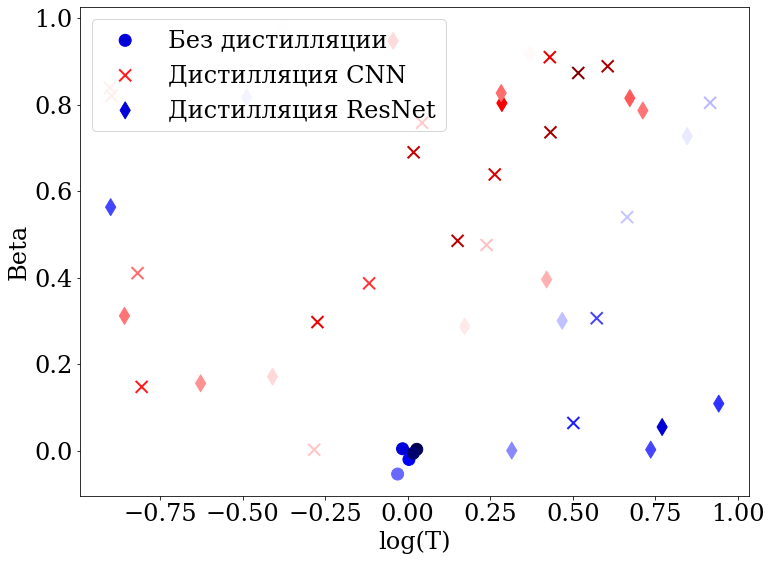

In [21]:
# график, разрез Temp-beta. Цвет --- точность относительно всех результатов

# для резульатов без дистилляции у нас будут повторяющиеся точки. 
# обычно в таком случае в график вносят небольшой шум, чтобы точки можно было визуально различить
eps = 0.02 

all_results = basic_results+[r[0] for r in cnn_results] + [r[0] for r in resnet_results]
max_ = np.max(all_results)
min_ = np.min(all_results)
colors = [cm.seismic((r-min_)/(max_-min_)) for r in basic_results]
plt.scatter(np.random.randn(len(basic_results))*eps, np.random.randn(len(basic_results))*eps, c=colors, label='Без дистилляции')
colors = [cm.seismic((r[0]-min_)/(max_-min_)) for r in cnn_results]
plt.scatter([np.log10(r[2]) + np.random.randn()*eps for r in cnn_results], [r[1] + np.random.randn()*eps for r in cnn_results], c=colors, marker='x', label='Дистилляция CNN')
colors = [cm.seismic((r[0]-min_)/(max_-min_)) for r in resnet_results]
plt.scatter([np.log10(r[2]) + np.random.randn()*eps for r in resnet_results], [r[1] + np.random.randn()*eps for r in resnet_results], c=colors, marker='d', label='Дистилляция ResNet')
plt.legend(loc='upper left')
plt.xlabel('log(T)')
plt.ylabel('Beta')
plt.savefig('../figs/scatter_temp_beta.pdf')